In [22]:
import csv
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.constants as cons
import numpy as np
import pathlib
 
def kl(wert_a,wert_b):
    if wert_a < wert_b:
        return True
    else:
        return False
 
def fac(i):
    result = 1
    for x in range(1,i+1):
        result = result*x
    return result
 
 
with open("in2.txt", "r") as datafile:
    readfile = csv.reader(datafile)
    data = []
    for row in readfile:
        str_row = row[0].split()
        int_row = []
        for i in str_row:
            int_row.append(float(i))
        data.append(int_row)
   
    N = int(data[0][0])
    t_max = data[0][1]
    t_delta = data[0][2]/100
    m= np.array(data[1:N+1])
    r = np.array(data[N+1:2*N+1])
    v = np.array(data[2*N+1:])


     
 
 
# schwerpunkt trafo
R = sum(m*r)/sum(m)
RV = sum(m*v)/sum(m)
r_transformed = r-R
v_transformed = v-RV
m_trans = m/sum(m)

zero = np.zeros((N,3))
 
def a_vec2(pos):
    dist = np.zeros((N, N, 3))
    for i in range(3):
        dist[:,:,i] = -np.subtract.outer(pos[:, i], pos[:, i])
    #dist = np.subtract.outer(r, r) # not yet -> (N x N x 3)
    betrag1 = np.linalg.norm(dist, axis = 2)
    betrag = np.copy(betrag1)
    np.place(betrag,betrag==0,[1])
    fraction= np.zeros((N, N, 3))
    for i in range(3):
        fraction[:,:,i] = dist[:,:,i] / (betrag * betrag * betrag)
   
    return np.dot(m[:,0], fraction), betrag1 # (N x 3)
 
# dist = np.zeros((N,N,3))
# for n in range(N):
#     for j in range(N):
#         if n!=j:
#             dist[n,j,:]= (r_transformed[n,:]-r_transformed[j,:])/np.dot(r_transformed[n,:]-r_transformed[j,:],r_transformed[n,:]-r_transformed[j,:])**(3/2)
#         else:
#             for i in range(3):
#                 dist[n,n,i]= 0
 
# dist2 = np.zeros((N,N,3))
# for i in range(3):
#         dist2[:,:,i] = np.subtract.outer(r_transformed[:, i], r_transformed[:, i])
# betrag = np.linalg.norm(dist2, axis = 2)
# fraction= np.zeros((N, N, 3))
# for i in range(3):
#     fraction[:,:,i] = dist2[:,:,i] / (betrag * betrag * betrag)
#     np.nan_to_num(fraction,copy=False)
# print(dist==fraction)
# print(dist)
# print(fraction)
 
def a_vec(pos):
    a = np.zeros((N,3))
    for i in range(0,N):
        store = np.zeros((N,3))
        for j in range(0,N):
            if i!=j:
                store[j,:] = (m[j,0]*(pos[j,:]-pos[i,:])/(np.dot(pos[j,:]-pos[i,:],pos[j,:]-pos[i,:])**(3/2)))
        a[i,:] =sum(store)
    return a, j
 
# print(a_vec(r_transformed)[0]==a_vec1(r_transformed))
 
def dt_a(pos,vel):
    a = np.zeros((N,3))
    for i in range(0,N):
        store = np.zeros((N,3))
        for j in range(0,N):
            if i!=j:
                store[j,:] = (m[j,0]*((vel[j,:]-vel[i,:])/(np.dot(pos[j,:]-pos[i,:],pos[j,:]-pos[i,:])**(3/2))-3*np.dot(vel[j,:]-vel[i,:],pos[j,:]-pos[i,:])*(pos[j,:]-pos[i,:])/(np.dot(pos[j,:]-pos[i,:],pos[j,:]-pos[i,:])**(5/2))))
        a[i,:] = sum(store)
    return np.array(a) 
 
def dt_a2(pos,vel):
    dist = np.zeros((N, N, 3))
    distv = np.zeros((N, N, 3))
    for i in range(3):
        dist[:,:,i] = -np.subtract.outer(pos[:, i], pos[:, i])
    for i in range(3):
        distv[:,:,i] = -np.subtract.outer(vel[:, i], vel[:, i])
    #dist = np.subtract.outer(r, r) # not yet -> (N x N x 3)
    betrag = np.linalg.norm(dist, axis = 2)
    np.place(betrag,betrag==0,[1])
    fractionv= np.zeros((N, N, 3))
    for i in range(3):
        fractionv[:,:,i] = distv[:,:,i] / (betrag * betrag * betrag)
    v_dot_r = np.einsum('ijij->ij',np.tensordot(fractionv,dist,(2,2)))/betrag/betrag
    part2 = np.zeros((N,N,3))
    for i in range(3):
        part2[:,:,i] = dist[:,:,i]*v_dot_r
    whole = fractionv-3*part2
   
 
    return np.dot(m[:,0],whole) # (N x 3)
 
# def func(a,b):
#     return a/b
# rez = np.vectorize(func)
 
def energy1(pos,vel,betrag):
    v_sq= np.sum(vel*vel,axis=1)
    T= np.dot(m[:,0],v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        norm = np.linalg.norm(pos-pos[n],axis=1)
        np.place(norm,norm==0,['inf'])
        V[n]= np.dot(m[:,0],m[n,0]*1/norm)/2
    V = sum(V)
    return T-V
 
def energy(pos,vel,betrag):
    T = np.zeros(N)
    for n in range(N):
        T[n]= m[n,0]*np.dot(vel[n,:],vel[n,:])/2
    T = sum(T)
    V = np.zeros(N)
    for i in range(0,N):
        store = np.zeros((N))
        for j in range(0,N):
            if i!=j:
                store[j] = (m[j,0]*m[i,0]/(np.dot(pos[j,:]-pos[i,:],pos[j,:]-pos[i,:])**(1/2)))
        V[i] =sum(store)
    V = sum(V)/2
    return T+V
   
        
    
 
def energy2(pos,vel, betrag):
    T = np.dot(m[:,0],np.einsum('ii->i',np.tensordot(vel,vel,(1,1))/2))
    np.place(betrag,betrag==0,['inf'])
    r_rez = 1/betrag
  
    V = np.dot(m[:,0],np.dot(m[:,0],r_rez))/2
    return T-V
 
def total_angular_momentum(pos,vel):
   
    result = np.dot(m[:,0],np.cross(pos,vel,axisa=1,axisb=1))
    return result
 
def total_momentum(vel):
    result = np.dot(m[:,0],vel)
    return result
 

# cross = np.zeros((N,3))
# for n in range(N):
#     cross[n,:] = np.cross(r_transformed[n,:],v_transformed[n,:])
# print(cross==np.cross(r_transformed,v_transformed,axisa=1,axisb=1))
   
#für das Zweikörper für Aufgabe 2 Problem(noch nicht implementiert):
 
def j_vec(pos,vel):
    r = pos[0,:]-pos[1,:]
    v = vel[0,:]-vel[1,:]
    return r, v, np.cross(r,v)
 
def runge_lenz(r,v,j):
    return np.cross(v,j)/sum(m)-r/np.linalg.norm(r)
 
 
# iteratoren


 
 
def euler(pos,vel,tdelt):
    a,rij_betrag = a_vec(pos)
    dta = dt_a(pos,vel)
    vel1 = vel+a*tdelt
    pos = pos+vel*tdelt
    return pos, vel1, a, dta, rij_betrag
   
def euler_cromer(pos,vel,tdelt):
    a,rij_betrag = a_vec(pos)
    dta = dt_a(pos,vel)
    vel= vel+a*tdelt
    pos = pos+ vel*tdelt
    return pos, vel, a, dta, rij_betrag
 
def velo_verlet(pos,vel,a1,tdelt):
   
    pos = pos + vel*tdelt+a1*tdelt**2/2
    a2,rij_betrag = a_vec(pos)
    vel = vel +(a1+a2)*tdelt/2
    return pos, vel, a2, rij_betrag
 
def kick_drift(pos,vel,a1,tdelt):
    vel1 = vel+a1*tdelt/2
    pos = pos +vel1*tdelt
    a2,rij_betrag = a_vec(pos)
    vel = vel1 + a2*tdelt/2
    return pos, vel, a2, rij_betrag


def absol(x):
    absolute = []
    for vec in x:
        absolute.append(np.dot(vec,vec)**(1/2))
    return np.array(absolute)
 
def time_delta(a_iter,dta_iter):
    np.place(dta_iter,dta_iter==0,[0.0001])
   
    
    return min(absol(a_iter)/absol(dta_iter))
 

 

file = open('iteration_data.txt','w')
np.savetxt(file,r_transformed,fmt= '%.7e',delimiter=' ',newline=' ')
np.savetxt(file,v_transformed,fmt= '%.7e',delimiter=' ',newline='\n')
# with open('iteration_data.txt','r') as file:
#     x =np.loadtxt(file,ndmin=2)

file.close()

# file_r = open('iteration_data.txt','r')
# lines =file_r.readlines()
# r_lines = lines[0:-1:6]
# v_lines = lines[1:-1:6]
# t_lines = lines[2:-1:6]
# e_lines = lines[3:-1:6]
# amom_lines = lines[4:-1:6]
# mom_lines = lines[5:-1:6]



root = pathlib.Path.cwd()
paths =  root / 'e_data.txt', \
root / 'r_data.txt', \
root / 'v_data.txt', \
root / 't_data.txt', \
root / 'angmom_data.txt', \
root / 'mom_data.txt'
for path in paths:
    pathlib.Path.touch(path)
e_file = open(paths[0],'w')
r_file = open(paths[1],'w')
v_file = open(paths[2],'w')
t_file = open(paths[3],'w')
angmom_file = open(paths[4],'w')
mom_file = open(paths[5],'w')

t_sum = 0
delta_t=t_delta
t_max = 62
r_iter= r_transformed
v_iter= v_transformed
steps = 60000
last_extract = 0
while kl(t_sum,t_max):
    
    t_sum= t_sum+delta_t
    if t_sum>(last_extract+t_delta*15):
        t_file.write(f"{t_sum}"+"\n")
    r_iter, v_iter, a_iter, dta_iter,rij_betrag = euler(r_iter,v_iter,delta_t)
    delta_t = time_delta(a_iter,dta_iter)
    if kl(delta_t,t_delta-0.3*t_delta)==True:
        delta_t=t_delta-0.3*t_delta
    elif kl(t_delta+10*t_delta,delta_t)==True:
        delta_t=t_delta+10*t_delta
    if t_sum>(last_extract+t_delta*15):
        last_extract =t_sum
        e_file.write(f"{energy(r_iter,v_iter,rij_betrag)}"+"\n")
        np.savetxt(angmom_file,total_angular_momentum(r_iter,v_iter),fmt= '%.7e',delimiter=' ',newline=' ')
        np.savetxt(mom_file,total_momentum(v_iter),fmt= '%.7e',delimiter=' ',newline=' ')
        np.savetxt(r_file,r_iter,fmt= '%.7e',delimiter=' ',newline=' ')
        np.savetxt(v_file,v_iter,fmt= '%.7e',delimiter=' ',newline=' ')


e_file.close()
r_file.close()
v_file.close()
angmom_file.close()
mom_file.close()
t_file.close()






KeyboardInterrupt: 

(20000, 3)
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
62.000079999707495


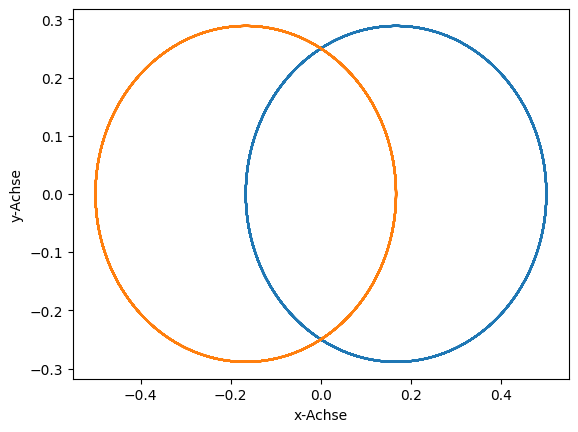

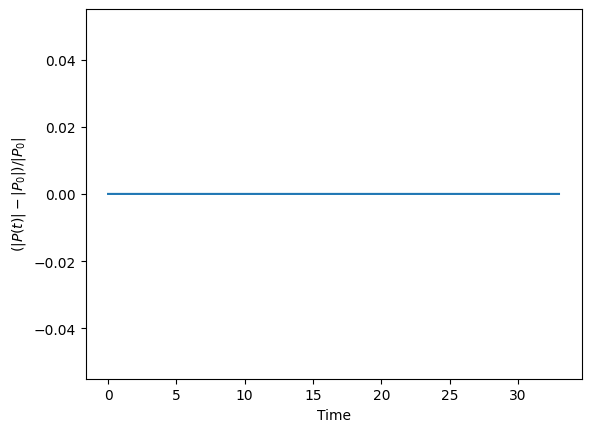

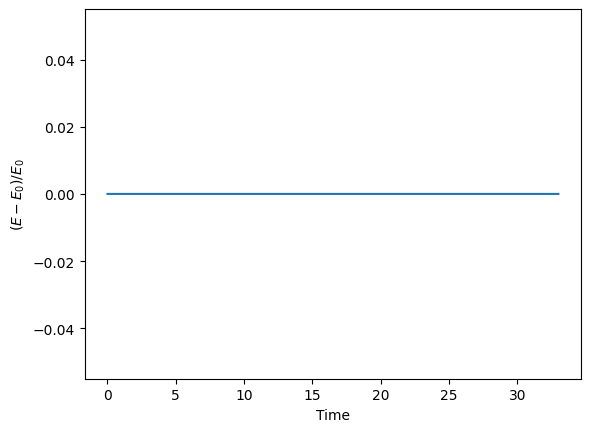

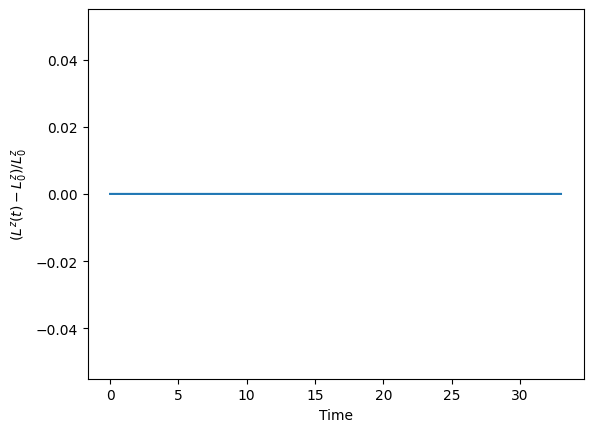

In [40]:
root = pathlib.Path.cwd()
paths =  root / 'e_data.txt', \
root / 'r_data.txt', \
root / 'v_data.txt', \
root / 't_data.txt', \
root / 'angmom_data.txt', \
root / 'mom_data.txt'


e_file = open(paths[0],'r')
r_file = open(paths[1],'r')
v_file = open(paths[2],'r')
t_file = open(paths[3],'r')
angmom_file = open(paths[4],'r')
mom_file = open(paths[5],'r')

course_r = np.loadtxt(r_file)
course_r =np.reshape(course_r,(300000//15,N,3))

course_v = np.loadtxt(v_file)
course_v =np.reshape(course_v,(300000//15,N,3))

c_energy = np.loadtxt(e_file)
c_tot_angm = np.loadtxt(angmom_file)
c_tot_angm = np.reshape(c_tot_angm,(300000//15,3))
c_totm = np.loadtxt(mom_file)
course_t = np.loadtxt(t_file)
e_file.close()
r_file.close()
v_file.close()
angmom_file.close()
mom_file.close()
t_file.close()


print(np.shape(c_tot_angm))
for i in range(20):
    print(c_tot_angm[i])
print(t_sum)
abs_momentum = np.linalg.norm(c_totm,axis=1) 
fig1, ax1 = plt.subplots(1,1)
for i in range(N):
    ax1.plot(course_r[:,i,0],course_r[:,i,1])
ax1.set_ylabel('y-Achse')
ax1.set_xlabel('x-Achse')
fig2, ax2 = plt.subplots(1,1)

ax2.plot(course_t,(abs_momentum-abs_momentum[0]))

ax2.set_xlabel('Time')
ax2.set_ylabel('$(|P(t)|-|P_0|)/|P_0|$')

fig3, ax3  = plt.subplots(1,1)

ax3.plot(course_t,(c_energy-c_energy[0])/c_energy[0])
ax3.set_ylabel('$(E-E_0)/E_0$')
ax3.set_xlabel('Time')
fig4 ,ax4 = plt.subplots(1,1)
ax4.plot(course_t,(c_tot_angm[:,2]-c_tot_angm[0,2])/c_tot_angm[0,2])
ax4.set_xlabel('Time')
ax4.set_ylabel('$(L^z(t)-L^z_0)/L^z_0$')


plt.show()

In [23]:
onefile = root / 'iteration_data.txt'

file = open(onefile,'w')

t_sum = 0
delta_t=t_delta
t_max = 62
r_iter= r_transformed
v_iter= v_transformed
steps = 60000
last_extract = 0
while kl(t_sum,t_max):
    
    t_sum= t_sum+delta_t
    if t_sum>(last_extract+t_delta*15):
        last_extract =t_sum
        file.write(f"\n{t_sum}")
    r_iter, v_iter, a_iter, dta_iter,rij_betrag = euler(r_iter,v_iter,delta_t)
    delta_t = time_delta(a_iter,dta_iter)
    if kl(delta_t,t_delta-0.3*t_delta)==True:
        delta_t=t_delta-0.3*t_delta
    elif kl(t_delta+10*t_delta,delta_t)==True:
        delta_t=t_delta+10*t_delta
    if t_sum>(last_extract+t_delta*15):
        last_extract =t_sum
        file.write(f', {energy(r_iter,v_iter,rij_betrag)}')
        for i in range(3):
            file.write(f', {total_angular_momentum(r_iter,v_iter)[i]}, {total_momentum(v_iter)[i]}')
        for n in range(N):
            for i in range(3):
                file.write(f', {r_iter[n,i]}, {v_iter[n,i]}')

file.close()
def energy_tot(pos,vel,betrag):
    v_sq= np.linalg.norm(vel,axis=2)
    T= np.dot(m[:,0],v_sq*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        norm = np.linalg.norm(pos-pos[:,n,:],axis=2)
        np.place(norm,norm==0,['inf'])
        V[n]= np.dot(m[:,0],m[n,0]*1/norm)/2
    V = sum(V)
    return T-V